In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pmdarima import auto_arima



In [5]:
df=pd.read_csv('C:/Users/wasan/Documents/Final Edition/Weather Data Set/Univariate/Kiriwaneliya_project.csv')
df.head()



,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max
0,2010,January,104.699999,11.0,20.2,NaN,NaN
1,2010,February,34.600000,12.0,22.1,NaN,NaN
2,2010,March,128.300001,11.5,23.0,NaN,NaN
3,2010,April,153.200000,13.1,22.5,NaN,NaN
4,2010,May,174.300002,14.1,21.7,NaN,NaN


In [6]:
df["Time"]=df["Year"].astype(str)+"-"+df["Month"].astype(str)

In [7]:
df.head()

,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Time
0,2010,January,104.699999,11.0,20.2,NaN,NaN,2010-January
1,2010,February,34.600000,12.0,22.1,NaN,NaN,2010-February
2,2010,March,128.300001,11.5,23.0,NaN,NaN,2010-March
3,2010,April,153.200000,13.1,22.5,NaN,NaN,2010-April
4,2010,May,174.300002,14.1,21.7,NaN,NaN,2010-May


In [8]:
hum_min=df[["Time","Hum_min"]]
hum_min.head()

,Time,Hum_min
0,2010-January,NaN
1,2010-February,NaN
2,2010-March,NaN
3,2010-April,NaN
4,2010-May,NaN


In [9]:
hum_min['Time']=pd.to_datetime(hum_min['Time'])


C:\Users\wasan\AppData\Local\Temp/ipykernel_7544/3648415634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hum_min['Time']=pd.to_datetime(hum_min['Time'])


In [10]:
hum_min.head()

,Time,Hum_min
0,2010-01-01,NaN
1,2010-02-01,NaN
2,2010-03-01,NaN
3,2010-04-01,NaN
4,2010-05-01,NaN


In [11]:
#Checking for missing values
hum_min.isna().sum()


Time        0
Hum_min    14
dtype: int64

In [12]:
#removing missing values
hum=hum_min.dropna(how="any")
hum.head()

,Time,Hum_min
12,2011-01-01,83.0
13,2011-02-01,77.0
14,2011-03-01,74.0
15,2011-04-01,75.0
16,2011-05-01,80.0


In [13]:
hum = hum.rename(columns = {'Hum_min': 'Humidity'})
hum.head()

,Time,Humidity
12,2011-01-01,83.0
13,2011-02-01,77.0
14,2011-03-01,74.0
15,2011-04-01,75.0
16,2011-05-01,80.0


In [14]:
hum.columns

Index(['Time', 'Humidity'], dtype='object')

In [15]:
#Setting the time index
hum.set_index('Time',inplace=True)

<AxesSubplot:xlabel='Time'>

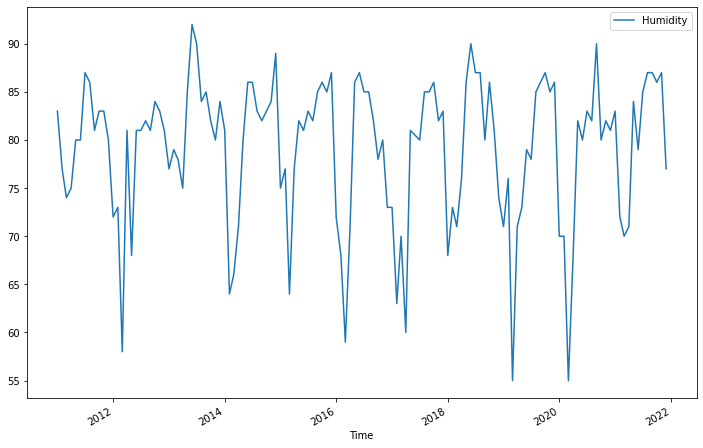

In [16]:
hum.plot(figsize=(12,8))

No trend. But some evidence for seasonality

# Testing For Stationarity

In [17]:
### ADF Test
test_result=adfuller(hum['Humidity'])
#Ho: The series is non stationary
#H1: The series is stationary

def adfuller_test(x):
    result=adfuller(x)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(hum['Humidity'])


ADF Test Statistic : -2.7487573097175355
p-value : 0.06597440705162655
#Lags Used : 10
Number of Observations Used : 119
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [18]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(hum['Humidity'])

KPSS Statistic: 0.09853338076344856
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [19]:
#PhillipsPerron Test
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(hum['Humidity'].astype(float))
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -5.366
P-value                         0.000
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# ACF and PACF plots

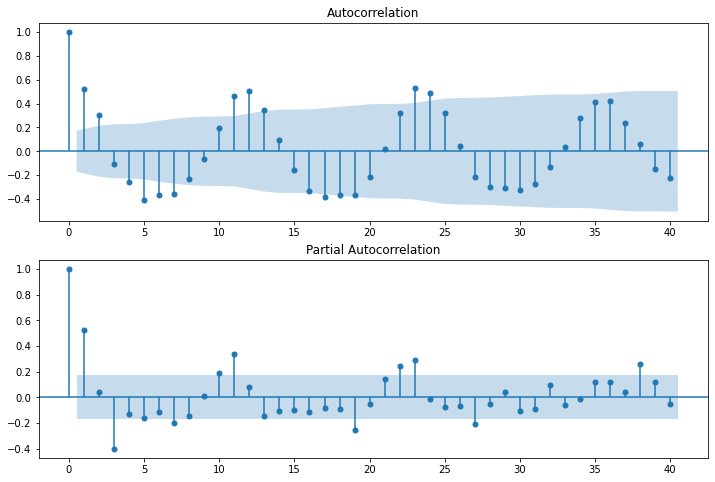

In [20]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(hum['Humidity'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(hum['Humidity'],lags=40,ax=ax2)

According to the PACF and ACF plots it's better to start with p=3, d=0, q=2

In [21]:
arima_model=auto_arima(hum['Humidity'].astype(float),start_p=0,start_d=0,start_q=0,max_p=3,max_D=1,max_q=2,start_P=0,start_D=0,start_Q=0,max_P=3,max_Q=2,m=12,seasonal=True,error_action='warn',trace=True,supress_warnings=True,stepwise=True,random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=898.519, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=846.284, Time=0.66 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=862.121, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1508.263, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=859.075, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=837.471, Time=0.71 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=845.445, Time=2.52 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=855.606, Time=1.46 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=836.860, Time=2.68 sec
 ARIMA(1,0,0)(3,0,2)[12] intercept   : AIC=inf, Time=3.76 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(0,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=1.98 sec
 ARIMA(2,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=3.11 sec
 ARIMA(1,0,1)(3,0,1)[12] intercept   : AIC=843.137, 

In [22]:
model=sm.tsa.statespace.SARIMAX(hum["Humidity"].astype('float'),order=(2, 0, 0),seasonal_order=(2,0,0,12))
results=model.fit()
results.summary()

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Humidity   No. Observations:                  130
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 12)   Log Likelihood                -426.442
Date:                            Wed, 06 Apr 2022   AIC                            862.884
Time:                                    12:29:42   BIC                            877.222
Sample:                                         0   HQIC                           868.710
                                            - 130                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4750      0.065      7.284      0.000       0.347       0.603
ar.L2          0.5121      0.070      7.293      0.000       0.374       0.650
ar.S.L12       0.3356      0.082      4.103      0.000       0.175       0.496
ar.S.L24       0.2922      0.109      2.679      0.007       0.078       0.506
sigma2        38.2236      4.931      7.752      0.000      28.560      47.888
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 1.84
Prob(Q):                              0.60   Prob(JB):                         0.40
Heteroskedasticity (H):               1.35   Skew:                            -0.19
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Time'>

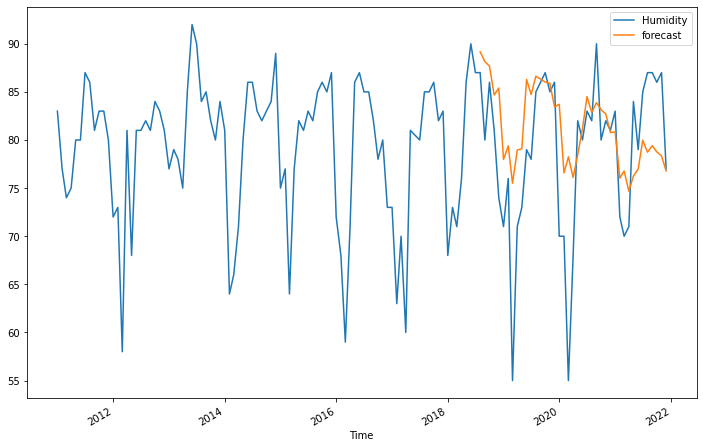

In [23]:
hum['forecast']=results.predict(start=90,end=129,dynamic=True)
hum[['Humidity','forecast']].plot(figsize=(12,8))

In [24]:
hum.tail()

,Humidity,forecast
Time,,
2021-08-01,87.0,78.731917
2021-09-01,87.0,79.410572
2021-10-01,86.0,78.760472
2021-11-01,87.0,78.357121
2021-12-01,77.0,76.776078
